# 向量 (张量) 数值导数与 RHF 核坐标数值梯度

上一节我们讨论了一元函数的数值导数，了解了三点差分法。三点差分法使用带逼近参数 $h$ 的表达式 $f^\mathrm{d} (x, h)$ 来逼近函数 $f'(x)$：

$$
f^\mathrm{d} (x, h) = \frac{f(x + h) - f(x - h)}{2h} \simeq f'(x)
$$

其中，若不受机器精度影响，$h$ 越小则 $f^\mathrm{d} (x, h)$ 越能逼近 $f'(x)$。

我们这一节，会用实际的化学中的例子，来说明向量，或者任意张量的一阶数值梯度的求取方式。

最简单的例子会是核坐标梯度。其比较直接的物理意义是，分子的受自身结构所受张力方向的相反值。一个分子并非在任何构型下都能稳定存在；一般来说，分子会处于稳定构型附近，而处在稳定构型的分子近乎不受自身结构张力，因此核坐标梯度接近零。

这个量可以用来进行分子动力学模拟，或结构优化。在本文段的最后，我们会拿几何结构优化 (必要条件是分子的核坐标梯度取到零值) 来举例，表明梯度计算在化学计算中的意义。

<div class="alert alert-warning">

**用法提醒**

下文会使用最简单的梯度下降法来进行结构优化；但这显然是非常糟糕的、仅作为演示所用的几何结构优化方案。请使用其它软件或量化库来进行真正有用的计算。

</div>

<div class="alert alert-info">

**提醒**

下文使用的分子会是氨分子。
    
在其它文档中，我们通常会使用的是变形的双氧水分子；这是因为变形双氧水分子的轨道能级不太简并，且原子数量大于 3，因此比较容易描述后文出现的 U 矩阵的行为、以及容易区别原子的维度与坐标的维度。

但变形双氧水分子的结构优化通常并不容易成功。因此，这篇文档会拿比较容易作结构优化的氨分子来作为例子。

</div>

In [1]:
%matplotlib notebook

from pyscf import gto, scf, lib
import numpy as np
import matplotlib.pyplot as plt
from pyxdh.Utilities import FormchkInterface, NucCoordDerivGenerator, NumericDiff

np.set_printoptions(5, linewidth=150, suppress=True)

## 氨分子量化程序的结构优化

### Gaussian 的几何结构优化

对于氨分子结构优化，我们可以使用下述的 Gaussian [输入卡](assets/NH3-opt.gjf) 进行计算：

In [2]:
with open("assets/NH3-opt.gjf", "r") as f:
    print(f.read())

%chk=NH3-opt
#p RHF/6-31G opt

NH3 Optimization

0 1
N  0.            0.   0.
H  0.            1.  -0.2
H  0.8660254038 -0.5 -0.2
H -0.8660254038 -0.5 -0.2



<div class="alert alert-info">

**提醒**

关于几何结构，需要留意单位的问题。我们不管是在 Gaussian 还是 PySCF 中，构建分子时，出于约定俗成，坐标 (作为长度) 的单位默认都是 Angstrom。但不管是在程序中，还是在运算的推导过程中，出于便利程度考虑，普遍使用的都是 Bohr 单位 (等同于原子单位 a.u.)。

后文若不作更多说明，我们将会统一使用 Bohr 单位。因此，上述未经过结构优化的氨分子的坐标若化为 Bohr 单位，则表示为 `coord_orig`；其中，`lib.param.BOHR` 是 PySCF 中内置的 Bohr 与 Angstrom 转换数。

</div>

In [3]:
natm = 4
coord_orig = 1 / lib.param.BOHR * np.array(
    [[ 0.          ,  0. ,  0. ],
     [ 0.          ,  1. , -0.2],
     [ 0.8660254038, -0.5, -0.2],
     [-0.8660254038, -0.5, -0.2]])
coord_orig

array([[ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  1.88973, -0.37795],
       [ 1.63655, -0.94486, -0.37795],
       [-1.63655, -0.94486, -0.37795]])

而 Gaussian 输出的优化完毕的分子结构，可以通过 [.fch 文件](assets/NH3-opt.fch) 给出 (在 Bohr 单位下)：

In [4]:
coord_g09 = FormchkInterface("assets/NH3-opt.fch").key_to_value("Current cartesian coordinates").reshape(4, 3)
coord_g09

array([[ 0.     ,  0.     ,  0.11243],
       [ 0.     ,  1.83562, -0.26234],
       [ 1.5897 , -0.91781, -0.26234],
       [-1.5897 , -0.91781, -0.26234]])

该分子在当前计算条件下，N-H 键长与 H-N-H 键角分别为 (单位分别为 Bohr，度)

In [5]:
bond_NH = np.linalg.norm(coord_g09[1] - coord_g09[0])
angle_HNH = np.arccos(np.dot(coord_g09[1] - coord_g09[0], coord_g09[2] - coord_g09[0]) / bond_NH**2) * 180 / np.pi
print("N-H Bond Length {:9.5f} Bohr".format(bond_NH))
print("H-N-H Angle     {:9.5f} Degree".format(angle_HNH))

N-H Bond Length   1.87349 Bohr
H-N-H Angle     116.10224 Degree


### PySCF 梯度下降的几何结构优化

我们整个文档的目的是求取 xDH 型泛函的梯度。比较相似的问题会是求取 RHF 的梯度。借助这个梯度，我们可以用最基本的梯度下降法，来求取与上面相同的最优化的几何结构。

首先，我们定义一个函数 `gen_NH3`，该函数将会读入 Bohr 半径单位的原子坐标，输出 PySCF 的分子实例。

In [6]:
def gen_NH3(coord):
    """
    Generate NH3 molecule (with basis 6-31G)
    """
    mol = gto.Mole()
    mol.atom = """
    N  0.            0.   0.
    H  0.            1.  -0.2
    H  0.8660254038 -0.5 -0.2
    H -0.8660254038 -0.5 -0.2
    """
    mol.basis = "6-31G"
    mol.verbose = 0
    mol.build()
    mol.set_geom_(coord * lib.param.BOHR)
    return mol.build()

梯度下降的大致过程是，我们首先认为，分子的自洽场能量 $E$ 可以写为分子坐标 $A_t$ 的函数。那么分子能量的梯度可以表示为

$$
E^{A_t} = \frac{\partial E(A_t)}{\partial A_t}
$$

关于分子结构的一些记号，请先参考 [分子结构](../qcbasic/basis_integral.ipynb#构型量输出) 一节的内容

<div class="alert alert-info">

**记号说明**

- 能量记号右上方的角标，表示对能量对该角标的全导数。

但其它情况下，右上方的角标一般表示 Skeleton 导数而非全导数。Skeleton 导数将会在下一章中进行描述。

</div>

$E^{A_t}$ 就称为能量对分子坐标的梯度 (gradient) 或导数 (derivative)。对于当前的分子，其维度是 $4 \times 3$；即标量值对矢量或矩阵的导数，该导数的维度即等价于原先矢量的维度。该梯度量储存在自洽场的梯度实例 `scf_grad` 的成员变量 `de` 中。

In [7]:
scf_eng = scf.RHF(gen_NH3(coord_orig)).run()
scf_grad = scf_eng.nuc_grad_method().run()
scf_grad.de

array([[-0.     ,  0.     ,  0.01145],
       [ 0.     ,  0.0265 , -0.00382],
       [ 0.02295, -0.01325, -0.00382],
       [-0.02295, -0.01325, -0.00382]])

获得这个梯度的意义是，如果分子的坐标沿着梯度的方向移动，那么其分子能量应会下降，从而更加接近能量的局域极小点。如果我们定义 (标量) 下降率 `lr` $\mathtt{lr}$，那么我们能期待

$$
\exists \mathtt{lr} > 0, \, \mathrm{s.t.} \, E(A_t - \mathtt{lr} \times E^{A_t}) < E(A_t)
$$

那么，如果我们选定一个下降率 $\mathtt{lr}$，每次用梯度矫正的分子坐标 $A_t - \mathtt{lr} \times E^{A_t}$ 替换校正前的坐标 $A_t$，一般地总可以优化到能量的极小点。这个过程就是梯度下降。

但其中存在两个问题：

- 这里的 $\mathtt{lr}$ 仅仅是存在，满足上述条件的 $\mathtt{lr}$ 并不见得容易获得；

- 矢量区别于标量的一个要点是梯度具有方向性，因此并不能保证沿着梯度下降就会是最好的局域优化方法。

上述的两个问题我们不会作太多展开，但可以对第一个问题作定性描述。我们可以绘制能量 $E(A_t - \mathtt{lr} \times E^{A_t})$ 随着 $\mathtt{lr}$ 而变化的曲线 (当 $\mathtt{lr}$ 恰好为零时，则就是我们一开始给的分子坐标下的能量 $E(A_t)$)：

In [8]:
lr_list = np.arange(0, 4, 0.1)
eng_list = [scf.RHF(gen_NH3(coord_orig - lr * scf_grad.de)).run().e_tot for lr in lr_list]

<IPython.core.display.Javascript object>


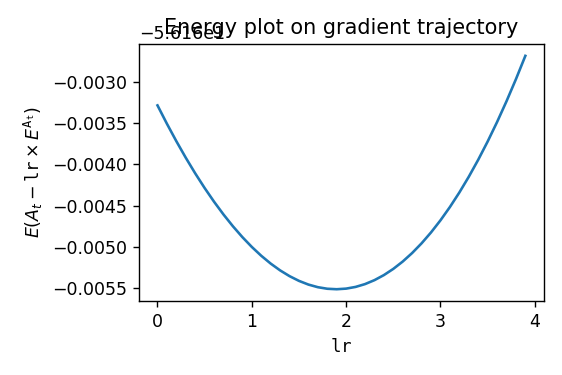

In [9]:
fig, ax = plt.subplots(figsize=(4.5, 3))
ax.plot(lr_list, eng_list)
ax.set_title("Energy plot on gradient trajectory")
ax.set_xlabel(r"$\mathtt{lr}$")
ax.set_ylabel(r"$E(A_t - \mathtt{lr} \times E^\mathtt{A_t})$")
fig.tight_layout()

因此，我们会发现对于当前的例子而言，$\mathtt{lr}$ 在 2 左右时将会给出较小的能量，但对当前情况来说，$0 < \mathtt{lr} < 4$ 时能给出相对更低的能量值。

经过测试，我们可以设定 $\mathtt{lr} = 1$，以进行梯度下降的几何结构优化。其优化过程和优化曲线如下：

In [10]:
coord = coord_orig.copy()
lr = 1
eng_threshold = 1e-8
eng_list = []
for _ in range(128):
    scf_eng = scf.RHF(gen_NH3(coord)).run()
    eng_list.append(scf_eng.e_tot)
    if len(eng_list) > 6 and np.abs(eng_list[-1] - eng_list[-4]) < eng_threshold:
        break
    grad_NH3 = scf_eng.nuc_grad_method().run().de
    coord -= lr * grad_NH3

我们最终得到的梯度下降得到的最低能量是

In [11]:
eng_list[-1]

-56.16552129763208

以及最终优化得到的原子坐标表示如下：

In [12]:
coord

array([[-0.     ,  0.     , -0.00446],
       [ 0.     ,  1.836  , -0.37646],
       [ 1.59002, -0.918  , -0.37646],
       [-1.59002, -0.918  , -0.37646]])

该分子的键长与键角如下：

In [13]:
bond_NH = np.linalg.norm(coord[1] - coord[0])
angle_HNH = np.arccos(np.dot(coord[1] - coord[0], coord[2] - coord[0]) / bond_NH**2) * 180 / np.pi
print("N-H Bond Length {:9.5f} Bohr".format(bond_NH))
print("H-N-H Angle     {:9.5f} Degree".format(angle_HNH))

N-H Bond Length   1.87330 Bohr
H-N-H Angle     116.15804 Degree


对比上面 Gaussian 的输出，可以发现这两者的几何结构非常相近；几何结构的优化是成功的。

## 数值梯度计算

### 能量的数值梯度计算

我们先简单回顾一下初始构型 `coord_orig` 下的原子坐标梯度：

In [14]:
scf_eng = scf.RHF(gen_NH3(coord_orig)).run()
scf_grad = scf_eng.nuc_grad_method().run()
scf_grad.de

array([[-0.     ,  0.     ,  0.01145],
       [ 0.     ,  0.0265 , -0.00382],
       [ 0.02295, -0.01325, -0.00382],
       [-0.02295, -0.01325, -0.00382]])

作为例子，我们指出上述梯度矩阵的第 0 行 (氮原子) 第 2 列 ($z$ 坐标分量) 的值，通过数值梯度也能得到。利用三点差分公式，我们定义逼近参数 $h = 10^{-4}$ Bohr，那么我们通过三点差分，通过这两个分子计算氮原子 $z$ 分量上的梯度：

In [15]:
def eng_deriv(coord):
    coord_m1 = coord.copy()
    coord_m1[0, 2] -= 1e-4                           # set coord_m1 as (x-h)
    coord_p1 = coord.copy()
    coord_p1[0, 2] += 1e-4                           # set coord_p1 as (x+h)
    eng_m1 = scf.RHF(gen_NH3(coord_m1)).run().e_tot  # get f(x-h)
    eng_p1 = scf.RHF(gen_NH3(coord_p1)).run().e_tot  # get f(x+h)
    return (eng_p1 - eng_m1) / 2e-4                  # return (f(x+h) - f(x-h)) / (2h)
eng_deriv(coord_orig)

0.011452969950198622

我们看到上述的数值差分结果与量化程序中给出的解析梯度是近乎相等的：

In [16]:
scf_grad.de[0, 2]

0.011453010014419451

以此类推，我们就可以给出所有原子的所有坐标分量的能量数值梯度了；将这些数值梯度拼成矩阵，就是量化程序所输出的解析梯度 $E^{A_t}$ 了。下面的程序 `num_grad` 就是输入任意氨分子，在逼近参数 $h = 10^{-4}$ Bohr 的情况下给出能量对核坐标的三点差分梯度：

In [17]:
def num_grad(coord):
    eng_grad = np.empty((natm, 3))
    for A in range(natm):
        for t in range(3):
            coord_m1 = coord.copy()
            coord_m1[A, t] -= 1e-4                           # set coord_m1 as (x - h)
            coord_p1 = coord.copy()
            coord_p1[A, t] += 1e-4                           # set coord_p1 as (x + h)
            eng_m1 = scf.RHF(gen_NH3(coord_m1)).run().e_tot  # get f(x-h)
            eng_p1 = scf.RHF(gen_NH3(coord_p1)).run().e_tot  # get f(x+h)
            eng_grad[A, t] = (eng_p1 - eng_m1) / 2e-4        # return (f(x+h) - f(x-h)) / (2h)
    return eng_grad
num_grad(coord_orig)

array([[ 0.     ,  0.     ,  0.01145],
       [-0.     ,  0.0265 , -0.00382],
       [ 0.02295, -0.01325, -0.00382],
       [-0.02295, -0.01325, -0.00382]])

该数值梯度近乎与 PySCF 给出的解析梯度相等。

因此，我们能预期，借助数值梯度，在稍低一些的收敛条件下，也可以对分子进行结构优化；但数值梯度的消耗相当大，因此进行梯度下降结构优化的时间也会相当长，就不作代码演示了。

### pyxdh 数值核坐标梯度程序

事实上，pyxdh 提供了方便求取核坐标的数值梯度程序。我们就拿处在 `coord_orig` 构型的分子的一阶导数来举例说明 pyxdh 程序的用法。这个程序将会在以后经常用于核验各种解析梯度与数值梯度之间是否相称。

我们首先生成核坐标梯度生成器 `NucCoordDerivGenerator` 的实例 `generator`；它必须的输入参数是

- 分子构型，在这里通过生成 NH3 的分子结构 `gen_NH3(coord_orig)` 给出。它必须是 PySCF 的 `gto.Mole` 类实例。

- 用于给出计算实例的函数。“计算实例”是指用于预先储存所有分子的某一种计算过程。在当前的例子而言，我们会计算分子的能量，即输入 `gto.Mole` 实例 `mol_`，输出 `scf.RHF` 实例 `scf.RHF(mol_).run()`；函数的形式是 lambda 函数。随着计算方式的不同，该函数也可以返回不同类型的实例。

In [18]:
generator = NucCoordDerivGenerator(gen_NH3(coord_orig), lambda mol_: scf.RHF(mol_).run())

在 `generator` 实例化过程中，会通过上述输入函数，预先计算好所有三点差分所需要的计算实例。这些计算实例将会储存在 `generator.objects` 成员变量中。譬如对于当前 NH3 分子的核坐标梯度，被求导的矩阵大小是 $4 \times 3 = 12$，因此 `generator.objects` 的第一维度是 12。而又由于我们使用三点差分，因此每个被求导量我们都需要求上下浮动 $h$ 的逼近参数的情形；因此每个被求导量的数值导数需要两个计算实例，即第二维度为 2：

In [19]:
generator.objects.shape

(12, 2)

而计算实例的类型与方才给 `NucCoordDerivGenerator` 实例化时调入的第二个参数 (lambda 函数) `lambda mol_: scf.RHF(mol_).run()` 的返回类型相同：

In [20]:
type(generator.objects[0, 0])

pyscf.scf.hf.RHF

但上述实例仅仅是生成了用于三点差分的计算实例的集合 `generator.objects`；真正计算三点差分的实例是通过实例化类 `NumericDiff` 生成的；它必须输入的参数是

- 梯度生成器；在当前的例子中，是 `generator`。

- 从计算实例导出具体数值的函数；在当前的例子中，我们需要从 `scf.RHF` 实例 `mf` 中，给出分子的能量信息，即 `mf.e_tot` 成员变量。

看起来，将生成三点差分的计算实例 (类 `NucCoordDerivGenerator` 的实例)、和具体计算三点差分的过程的拆分 (类 `NumericDiff` 的实例)，似乎是冗余的；但我们以后在具体验证 XYG3 型泛函导数性质时，将会发现非常有用。

In [21]:
diff = NumericDiff(generator, lambda mf: mf.e_tot)

上述三点差分实例 `diff` 可以用 `diff.derivative` 成员属性给出；我们可以发现，下述的数值导数与上面我们求过的数值导数近乎相等。

In [22]:
diff.derivative.reshape(natm, 3)

array([[ 0.     ,  0.     ,  0.01145],
       [ 0.     ,  0.0265 , -0.00382],
       [ 0.02295, -0.01325, -0.00382],
       [-0.02295, -0.01325, -0.00382]])

这里仅仅是介绍了使用 pyxdh 作核坐标能量梯度的计算方式。事实上，由于 pyxdh 的编写过程中还经常处理电场导数、以及对矩阵的导数，因此 pyxdh 的数值导数还有其它的用法。我们会在后面的偶极矩文段中介绍电场导数类 `DipoleDerivGenerator`，以及在 Hessian、极化率或红外相关文段中介绍对矩阵的导数。